In [ ]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np


from pathlib import Path
from collections import Counter

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the Dataset
direc = Path("/content/drive/MyDrive/samples") #change path

dir_img = sorted(list(map(str, list(direc.glob("*.png")))))
img_labels = [img.split(os.path.sep)[-1].
			split(".png")[0] for img in dir_img]
char_img = set(char for label in img_labels for char in label)
char_img = sorted(list(char_img))

print("Number of dir_img found: ", len(dir_img))
print("Number of img_labels found: ", len(img_labels))
print("Number of unique char_img: ", len(char_img))
print("Characters present: ", char_img)

# Batch Size of Training and Validation
batch_size = 16

# Setting dimensions of the image
img_width = 200
img_height = 50

# Setting downsampling factor
downsample_factor = 4

# Setting the Maximum Length
max_length = max([len(label) for label in img_labels])

# Char to integers
char_to_num = layers.StringLookup(
	vocabulary=list(char_img), mask_token=None
)

# Integers to original chaecters
num_to_char = layers.StringLookup(
	vocabulary=char_to_num.get_vocabulary(),
	mask_token=None, invert=True
)


def data_split(dir_img, img_labels,
			train_size=0.9, shuffle=True):
	# Get the total size of the dataset
	size = len(dir_img)
	# Create an indices array and shuffle it if required
	indices = np.arange(size)
	if shuffle:
		np.random.shuffle(indices)
	# Calculate the size of training samples
	train_samples = int(size * train_size)
	# Split data into training and validation sets
	x_train, y_train = dir_img[indices[:train_samples]], img_labels[indices[:train_samples]]
	x_valid, y_valid = dir_img[indices[train_samples:]], img_labels[indices[train_samples:]]
	return x_train, x_valid, y_train, y_valid


# Split data into training and validation sets
x_train, x_valid, y_train, y_valid = data_split(np.array(dir_img), np.array(img_labels))


def encode_sample(img_path, label):
	# Read the image
	img = tf.io.read_file(img_path)
	# Converting the image to grayscale
	img = tf.io.decode_png(img, channels=1)
	img = tf.image.convert_image_dtype(img, tf.float32)
	# Resizing to the desired size
	img = tf.image.resize(img, [img_height, img_width])
	# Transposing the image
	img = tf.transpose(img, perm=[1, 0, 2])
	# Mapping image label to numbers
	label = char_to_num(tf.strings.unicode_split(label,
												input_encoding="UTF-8"))

	return {"image": img, "label": label}


Number of dir_img found:  1040
Number of img_labels found:  1040
Number of unique char_img:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [ ]:
# Creating training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = (
	dataset_train.map(
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE
	)
	.batch(batch_size)
	.prefetch(buffer_size=tf.data.AUTOTUNE)
)


# Creating validation dataset
val_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_data = (
	val_data.map(
		encode_sample, num_parallel_calls=tf.data.AUTOTUNE
	)
	.batch(batch_size)
	.prefetch(buffer_size=tf.data.AUTOTUNE)
)


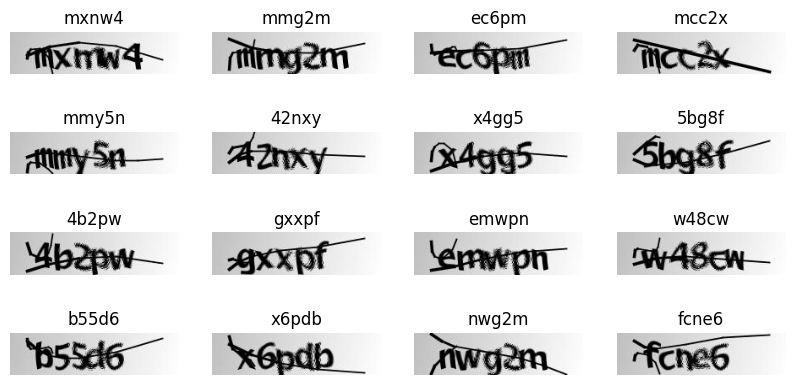

In [ ]:
# Visualizing some training data
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in dataset_train.take(1):
	dir_img = batch["image"]
	img_labels = batch["label"]
	for i in range(16):
		img = (dir_img[i] * 255).numpy().astype("uint8")
		label = tf.strings.reduce_join(num_to_char(
			img_labels[i])).numpy().decode("utf-8")
		ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
		ax[i // 4, i % 4].set_title(label)
		ax[i // 4, i % 4].axis("off")
plt.show()



In [ ]:
# CTC loss calculation
class LayerCTC(layers.Layer):
	def __init__(self, name=None):
		super().__init__(name=name)
		self.loss_fn = keras.backend.ctc_batch_cost

	def call(self, y_true, y_pred):
		# Compute the training-time loss value
		batch_len = tf.cast(tf.shape(y_true)[0],
							dtype="int64")
		input_length = tf.cast(tf.shape(y_pred)[1],
							dtype="int64")
		label_length = tf.cast(tf.shape(y_true)[1],
							dtype="int64")

		input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
		label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

		loss = self.loss_fn(y_true, y_pred,input_length, label_length)
		self.add_loss(loss)

		# Return Computed predictions
		return y_pred


def model_build():
	# Define the inputs to the model
	input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
	img_labels = layers.Input(name="label",
							shape=(None,),
							dtype="float32")

	# First convolutional block
	x = layers.Conv2D(
		32,
		(3, 3),
		activation="relu",
		kernel_initializer="he_normal",
		padding="same",
		name="Conv1",
	)(input_img)
	x = layers.MaxPooling2D((2, 2), name="pool1")(x)

	# Second convolutional block
	x = layers.Conv2D(
		64,
		(3, 3),
		activation="relu",
		kernel_initializer="he_normal",
		padding="same",
		name="Conv2",
	)(x)
	x = layers.MaxPooling2D((2, 2), name="pool2")(x)

	# Reshaping the output before passing to RNN
	new_shape = ((img_width // 4), (img_height // 4) * 64)
	x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
	x = layers.Dense(64, activation="relu", name="dense1")(x)
	x = layers.Dropout(0.2)(x)

	# RNNs
	x = layers.Bidirectional(layers.LSTM(
		128, return_sequences=True, dropout=0.25))(x)
	x = layers.Bidirectional(layers.LSTM(
		64, return_sequences=True, dropout=0.25))(x)

	# Output layer
	x = layers.Dense(
		len(char_to_num.get_vocabulary()) + 1,
		activation="softmax", name="dense2"
	)(x)

	# Calculate CTC loss at each step
	output = LayerCTC(name="ctc_loss")(img_labels, x)

	# Defining the model
	model = keras.models.Model(
		inputs=[input_img, img_labels],
		outputs=output,
		name="ocrcaptcha"
	)
	opt = keras.optimizers.Adam()

	# Compile the model
	model.compile(optimizer=opt)

	return model


In [ ]:
# Build the model
model = model_build()
model.summary()


Model: "ocrcaptcha"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                         

In [ ]:
# Early Stopping Parameters and EPOCH
epochs = 100
early_stopping_patience = 20


early_stopping = keras.callbacks.EarlyStopping(
	monitor="val_loss",
	patience=early_stopping_patience,
	restore_best_weights=True
)

# Training the model
history = model.fit(
	dataset_train,
	validation_data=val_data,
	epochs=epochs,
	callbacks=[early_stopping], verbose=1
)


Epoch 1/100
59/59 [==============================] - 42s 713ms/step - loss: 16.8071 - val_loss: 16.3359
Epoch 2/100
59/59 [==============================] - 26s 445ms/step - loss: 16.3651 - val_loss: 16.3275
Epoch 3/100
59/59 [==============================] - 23s 382ms/step - loss: 16.3507 - val_loss: 16.3250
Epoch 4/100
59/59 [==============================] - 24s 403ms/step - loss: 16.3448 - val_loss: 16.3242
Epoch 5/100
59/59 [==============================] - 22s 380ms/step - loss: 16.3407 - val_loss: 16.3249
Epoch 6/100
59/59 [==============================] - 22s 370ms/step - loss: 16.3311 - val_loss: 16.3106
Epoch 7/100
59/59 [==============================] - 24s 403ms/step - loss: 16.3284 - val_loss: 16.3109
Epoch 8/100
59/59 [==============================] - 22s 370ms/step - loss: 16.3129 - val_loss: 16.3032
Epoch 9/100
59/59 [==============================] - 22s 370ms/step - loss: 16.3035 - val_loss: 16.3167
Epoch 10/100
59/59 [==============================] - 24s 406ms/

In [ ]:
# Save the trained model
model.save('ocrcaptcha.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the .h5 model
path = '/content/drive/MyDrive/ocrcaptcha.h5'
#model = keras.models.load_model(model_path)

model = tf.keras.models.load_model(
       (path),
       custom_objects={'LayerCTC': LayerCTC}
)

In [ ]:
# Get the Model
prediction_model = keras.models.Model(
	model.get_layer(name="image").input,
	model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
	input_len = np.ones(pred.shape[0]) * pred.shape[1]
	results = keras.backend.ctc_decode(pred,
									input_length=input_len,
									greedy=True)[0][0][
		:, :max_length
	]
	output_text = []
	for res in results:
		res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
		output_text.append(res)
	return output_text


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

1/1 [==============================] - 0s 89ms/step


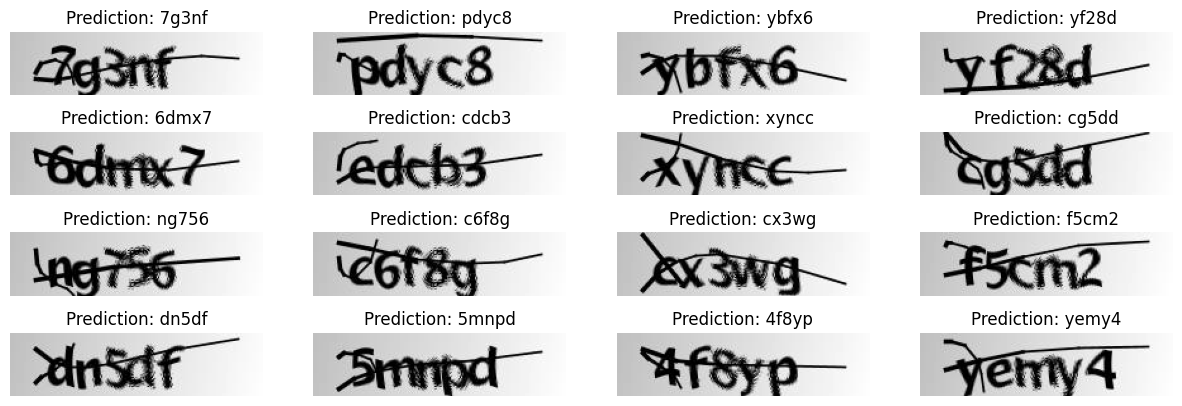

In [ ]:
# Check the validation on a few samples
for batch in val_data.take(1):
	batch_images = batch["image"]
	batch_labels = batch["label"]

	preds = prediction_model.predict(batch_images)
	pred_texts = decode_batch_predictions(preds)


	orig_texts = []
	for label in batch_labels:
		label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
		orig_texts.append(label)


	_, ax = plt.subplots(4, 4, figsize=(15, 5))
	for i in range(len(pred_texts)):
		img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
		img = img.T
		title = f"Prediction: {pred_texts[i]}"
		ax[i // 4, i % 4].imshow(img, cmap="gray")
		ax[i // 4, i % 4].set_title(title)
		ax[i // 4, i % 4].axis("off")
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# Define the custom layer class
class LayerCTC(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

# Wrap the loading process in a custom object scope
with custom_object_scope({'LayerCTC': LayerCTC}):
    # Load the saved model
    loaded_model = load_model('/content/drive/MyDrive/ocrcaptcha.h5')

In [ ]:
import os

# Assuming you have a single image path
single_image_path = '/content/drive/MyDrive/samples/3ebpw.png'

# Extract the label from the single image file name
single_label = os.path.splitext(os.path.basename(single_image_path))[0]

1/1 [==============================] - 0s 63ms/step


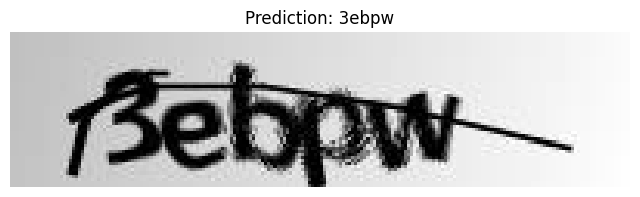

In [ ]:
# Setting dimensions of the image
img_width = 200
img_height = 50

single_encoded_sample = encode_sample(single_image_path, single_label)

# Extract the image and label
single_image = single_encoded_sample["image"]
#single_label = single_encoded_sample["label"]

# Read the image and preprocess it
single_image = tf.io.read_file(single_image_path)
single_image = tf.io.decode_png(single_image, channels=1)
single_image = tf.image.convert_image_dtype(single_image, tf.float32)
single_image = tf.image.resize(single_image, [img_height, img_width])
single_image = tf.transpose(single_image, perm=[1, 0, 2])  # Assuming you need to transpose the image

# Reshape the image to match the expected input shape
single_image = tf.expand_dims(single_image, axis=0)  # Add batch dimension

# Get the prediction for the single image
single_pred = prediction_model.predict(single_image)

# Decode the prediction and the original label
single_pred_text = decode_batch_predictions(single_pred)[0]
#single_orig_text = tf.strings.reduce_join(num_to_char(single_label)).numpy().decode("utf-8")

# Visualize the single image and prediction
plt.figure(figsize=(8, 4))
img = (single_image[0, :, :, 0] * 255).numpy().astype(np.uint8).T
plt.imshow(img, cmap="gray")
plt.title(f"Prediction: {single_pred_text}")#\nOriginal: {single_orig_text}")
plt.axis("off")
plt.show()
